In [1]:
from datetime import datetime

from finance_utils.backtest import Backtest
import yfinance as yf
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from_beginning = '1987-01-01'
# hang seng index start: 1987-01-01
name = '^HSI'

In [3]:
start_date = from_beginning
df = yf.download(name, start=start_date)

[*********************100%%**********************]  1 of 1 completed


In [4]:
today = datetime.now()
last_10_years = f'{today.year - 9}-01-01'
last_20_years = f'{today.year - 19}-01-01'
last_30_years = f'{today.year - 29}-01-01'
start_date = f'1900-01-01'
choices = [last_10_years, last_20_years, last_30_years, start_date]

In [5]:
open_m = df['Open'].groupby([df.index.year, df.index.month]).first()
close_m = df['Close'].groupby([df.index.year, df.index.month]).last()
df_m = pd.DataFrame()
df_m['Open'] = open_m
df_m['Close'] = close_m
df_m.index.names = ['Year', 'Month']
df_m = df_m.reset_index()
df_m.index = [f"{df_m['Year'].iloc[i]}-{df_m['Month'].iloc[i]}-1" for i in range(len(df_m))]
df_m

,Year,Month,Open,Close
1987-1-1,1987,1,2540.100098,2553.300049
1987-2-1,1987,2,2585.199951,2877.899902
1987-3-1,1987,3,2894.300049,2713.800049
1987-4-1,1987,4,2695.899902,2659.899902
1987-5-1,1987,5,2685.399902,2950.800049
...,...,...,...,...
2024-4-1,2024,4,16811.740234,17763.029297
2024-5-1,2024,5,17760.679688,18079.609375
2024-6-1,2024,6,18283.560547,17718.609375
2024-7-1,2024,7,17669.419922,17344.599609


1-2, 3-4, ..., 11-12

In [6]:
def get_x_months_results(_df_, _time, x):
    returns = []
    months = []
    years = []
    _df = _df_[_df_.index >= _time].copy().reset_index()
    
    for i in range(0, _df.shape[0] - (x - 1)):
        res = _df.loc[i + x - 1, 'Close'] / _df.loc[i, 'Open'] - 1
        time = str(_df.loc[i, 'Month']) + '-' + str(_df.loc[i + x - 1, 'Month'])
        
        returns.append(res)
        months.append(time)
        years.append(str(_df.loc[i, 'Year']) + '-' + str(_df.loc[i + x - 1, 'Year']))
    
    df_12 = pd.DataFrame({'Return': returns, 'Months': months, 'Years': years})
    
    table_12 = df_12.groupby('Months')['Return'].describe()
    table_12['mean / std'] = table_12['mean'] / table_12['std']
    table_12['Win Rate %'] = (df_12.groupby('Months')['Return'].apply(lambda y: (y > 0).sum()) 
                              / table_12['count'] * 100)
    table_12 = table_12.reset_index()

    # months = {f'{i + 1}-': i + 1 for i in range(12)}
    months = {(f'{i + 1}-{i + x}' if i + x <= 12 else f'{i + 1}-{i + x - 12}'): i + 1 for i in range(12)}
    
    indexes = [months[m] for m in table_12['Months']]
    table_12.index = indexes
    table_12.index.name = _time if _time != '1900-01-01' else from_beginning
    
    table_12 = table_12.sort_index()
    return table_12

In [24]:
get_x_months_results(df_m, from_beginning, 6)

,Months,count,mean,std,min,25%,50%,75%,max,mean / std,Win Rate %
1987-01-01,,,,,,,,,,,
1,1-6,38.0,0.041751,0.158553,-0.263065,-0.063991,0.030069,0.133969,0.420404,0.263323,52.631579
2,2-7,38.0,0.060801,0.179883,-0.232875,-0.067670,0.063190,0.169913,0.559294,0.338005,55.263158
3,3-8,38.0,0.024303,0.173043,-0.366655,-0.092418,-0.005447,0.122544,0.575086,0.140444,47.368421
4,4-9,37.0,0.027712,0.194204,-0.313957,-0.112016,0.029541,0.132979,0.524442,0.142698,59.459459
5,5-10,37.0,0.010096,0.205466,-0.469376,-0.149602,0.014479,0.110411,0.538095,0.049136,56.756757
6,6-11,37.0,0.018434,0.183369,-0.434110,-0.112761,0.028290,0.155092,0.382596,0.100527,56.756757
7,7-12,37.0,0.037077,0.200893,-0.339581,-0.097408,0.048496,0.166222,0.669789,0.184559,56.756757
8,8-1,37.0,0.023665,0.207807,-0.436660,-0.086454,0.019008,0.151298,0.643583,0.113880,54.054054
9,9-2,37.0,0.055377,0.176762,-0.389905,-0.052108,0.042802,0.176611,0.400662,0.313286,72.972973


In [25]:
x_months = 6

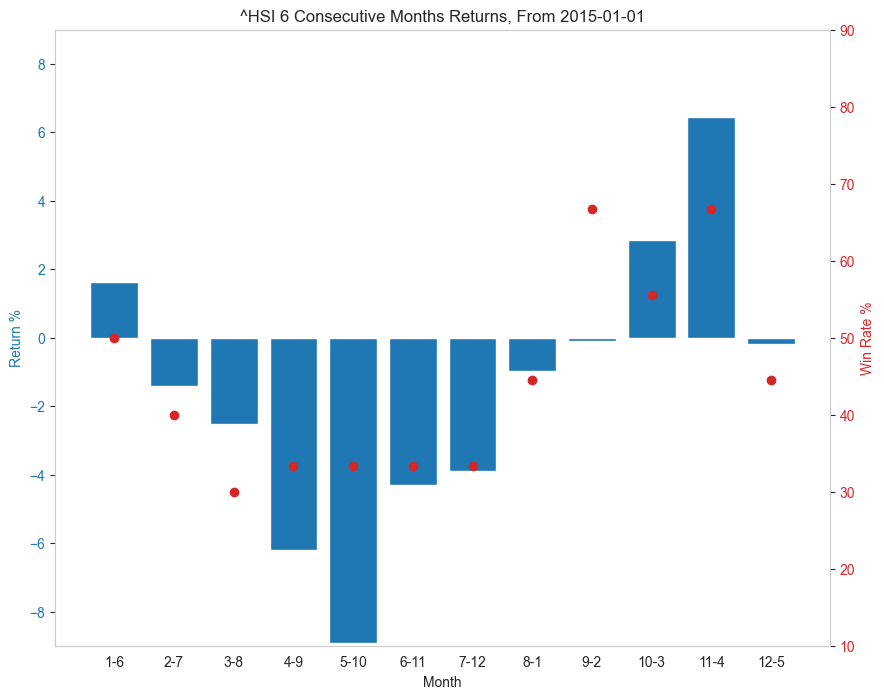

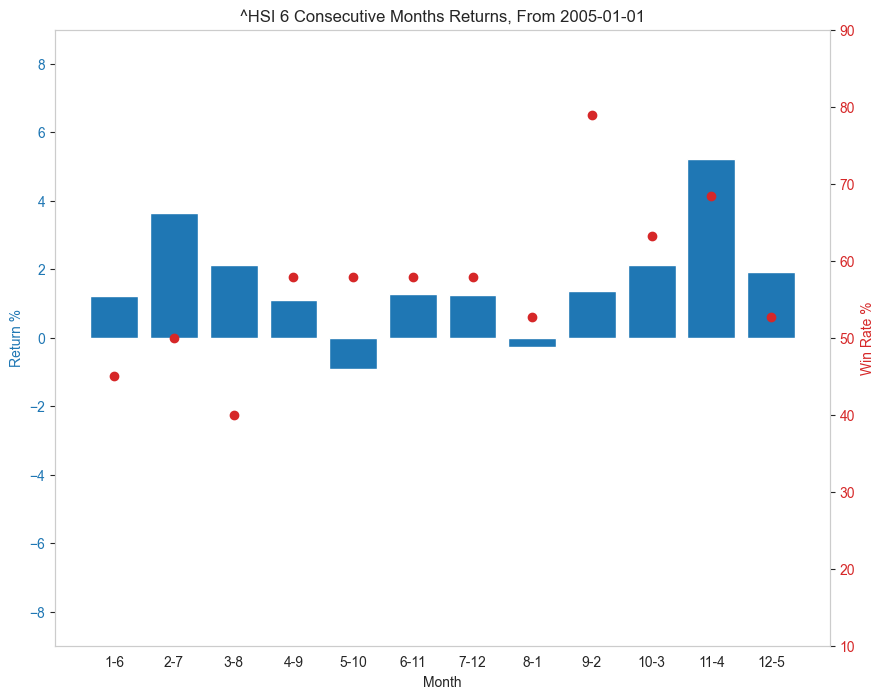

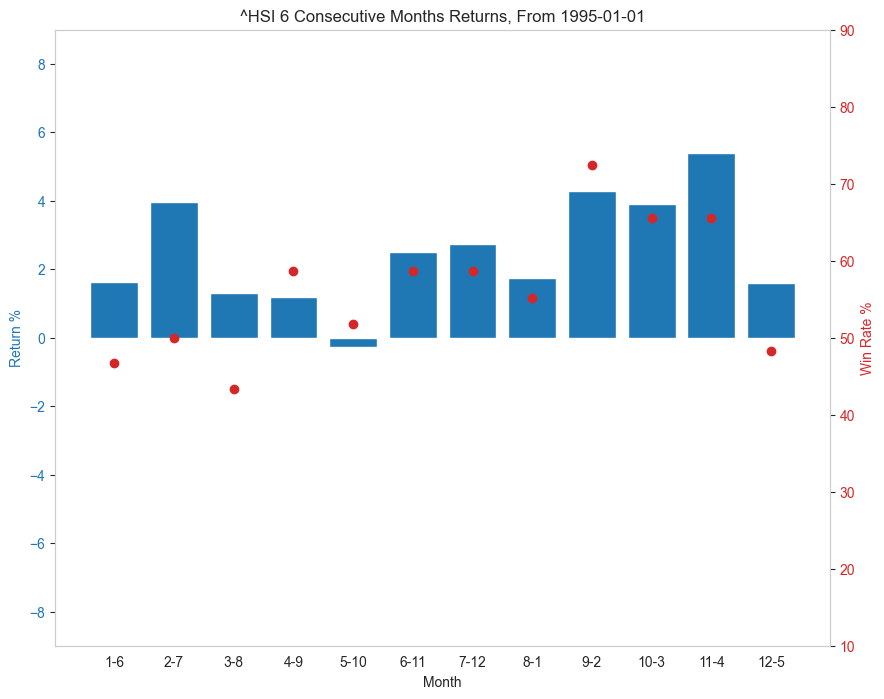

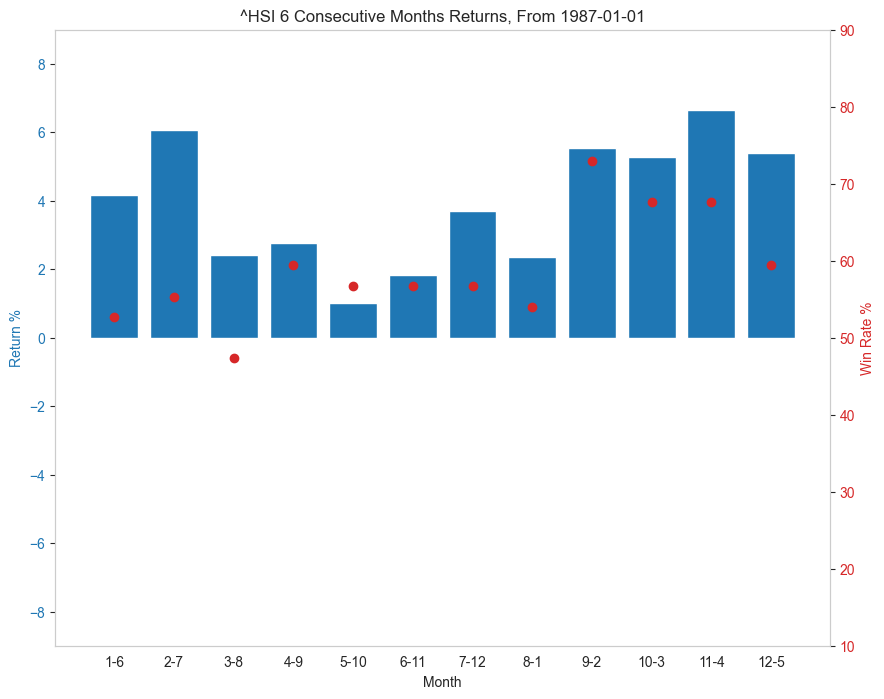

In [29]:
for n, t in enumerate(choices):
    _df = get_x_months_results(df_m, t, x_months)
    
    fig, ax1 = plt.subplots(figsize=(10, 8))
    plt.grid(False)
    color = 'tab:blue'
    ax1.set_xlabel('Month')
    ax1.set_ylabel('Return %', color=color)
    ax1.bar(x=_df['Months'], height=_df['mean'] * 100, color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.set_ylim(-9, 9)
    
    ax2 = ax1.twinx()  # instantiate a second Axes that shares the same x-axis
    plt.grid(False)
    color = 'tab:red'
    ax2.set_ylabel('Win Rate %', color=color)  # we already handled the x-label with ax1
    ax2.scatter(x=_df['Months'], y=_df['Win Rate %'], color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.set_ylim(10, 90)

    years = _df.index.name
    plt.title(f'{name} {x_months} Consecutive Months Returns, From {_df.index.name}')
    plt.show()